<a href="https://colab.research.google.com/github/Naomi-Kenyatta/corporateSocialAdvocacy/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np

#Classification of Coporate Social Advoacy

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.utils
import re
import os
from gensim.models import KeyedVectors

In [ ]:
import gensim.downloader

model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Defining a function named 'merge' that takes two arguments: 'df' (DataFrame) and 'fileName' (string)
# It merges the file into the dataframe and sets all the titles that aren't in the OG df as 0
def merge(df, fileName):
    df[["CSA"]] = 1
    company = pd.read_csv(fileName)[["title"]].drop_duplicates()

    merged_df = pd.merge(company, df, on=["title"], how="outer", indicator=True)

    # Updating the "CSA" column to 0 for rows that are only present in the 'df' DataFrame but not in the 'company' DataFrame
    merged_df.loc[merged_df["_merge"] == "left_only", "CSA"] = 0

    # Selecting only the "title" and "CSA" columns from the merged DataFrame and printing the first few rows
    print(merged_df[["title","CSA"]].sample(5))
    return merged_df[["title","CSA"]]

In [ ]:
df = pd.read_csv("df.csv")[["title"]].drop_duplicates()
df = merge(df,"adobe.csv")
df = merge(df,"chevron.csv")

                                                   title  CSA
18041  gsa administrator and opm director to deliver ...  0.0
19816                    rediscovery: woody's prose song  0.0
55247  pfizer to award more than 3 million in grants ...  1.0
49049          dealbook i want to try to enjoy every day  1.0
6263   practice fusion doubles office space with new ...  0.0
                                                   title  CSA
25947  pr newswire national summary, tuesday, august ...  1.0
55155  herman cain who shed executive title to run fo...  1.0
54665     letter why greek life is a positive experience  1.0
22010  battered, flooded and submerged: many superfun...  0.0
25031  ty cobb and babe ruth, the first baseball hall...  1.0


In [ ]:
#undersampling to keep an equal number of CSA to Not CSA
counts = df['CSA'].value_counts()
min_count = counts.min()
grouped = df.groupby('CSA')
balanced_df = grouped.apply(lambda x: x.sample(min_count)).reset_index(drop=True)
print(balanced_df['CSA'].value_counts())
df = balanced_df

CSA
0.0    2967
1.0    2967
Name: count, dtype: int64


In [ ]:
# Remove stop words from the titles in the DataFrame,
word_file = 'stopwords.txt'

with open(word_file, 'r') as file:
    words = file.readlines()

word_dict = {word.strip(): None for word in words}
df = df[~df['title'].str.split().apply(lambda x: any(item in word_dict for item in x))]

In [ ]:
# Normalize the titles by removing non-alphabetic characters,
df["title"] = df['title'].str.replace('[^a-zA-Z]', ' ', regex=True)
words_list = df["title"].str.split().explode()
unique_words = set(words_list)
unique_words_list = list(unique_words)

,title,CSA
0,law enforcement silver city police blotter,0.0
4,law enforcement grant county sheriff,0.0
7,police blotter august,0.0
10,originalism inc,0.0
14,west county schools budget update outlines dif...,0.0
...,...,...
92270,africanamerican cpd lieutenant fellow cops racist,1.0
92271,black cincinnatians shining examples,1.0
92273,fifth third revises sexbias policy,1.0
92277,fifth third settles loan bias suit,1.0


In [ ]:
# Extract unique words
df["title"] = df['title'].str.replace('[^a-zA-Z]', ' ', regex=True)
words_list = df["title"].str.split().explode()
unique_words = set(words_list)
unique_words_list = list(unique_words)

#create a dictionary that maps the words to model value
dictWord = {}
for word in list(unique_words_list):
  if word in model.key_to_index.keys():
    dictWord[word] = model[word]

In [ ]:
# Create the word embedding for each sentance
W2Vec_Data = pd.DataFrame()

for _, row in df.iterrows():
    sentence = np.zeros(300)

    for word in row["title"].split(" "):
        if word in dictWord:
            sentence += dictWord[word]

    W2Vec_Data = pd.concat([W2Vec_Data, pd.DataFrame([sentence])], ignore_index=True)

W2Vec_Data.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.191528,-0.116089,-0.116211,0.483887,0.084961,-0.007507,-0.041534,0.010498,-0.076294,0.008301,...,0.233887,0.140625,0.019226,0.041260,-0.228027,-0.245117,-0.183105,-0.113525,0.054337,0.254883
1,0.094055,-0.044800,0.162109,-0.056274,0.044922,-0.327148,0.292603,-0.540527,0.329071,-0.064697,...,-0.375732,0.205811,-0.643311,0.048340,-0.263428,-0.333801,0.509811,0.406189,-0.092773,0.189453
2,-0.258789,0.875671,-0.057007,0.289642,-1.101562,0.682495,0.038574,0.111450,0.636719,0.485016,...,0.143066,0.178711,-0.541138,0.490723,0.476562,0.464844,-0.015015,0.007324,0.180237,0.325317
3,-0.120728,0.153320,-0.004761,0.297882,0.041107,-0.129883,-0.066162,-0.273651,0.154297,0.513672,...,-0.109375,-0.083984,-0.418945,0.150391,-0.209534,-0.419067,-0.590820,0.029907,0.393555,0.554688
4,-0.116150,0.419556,0.174805,0.625977,-0.316406,0.007080,0.038574,-0.266113,-0.178833,0.615723,...,-0.429932,-0.237976,-0.766602,0.570312,-0.252441,0.090088,0.150879,0.393799,0.295898,0.014435


In [ ]:
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['CSA']= df[['CSA']].reset_index()["CSA"]

# Assigning to DataForML variable
DataForML=W2Vec_Data
DataForML.to_csv("DataForML.csv")

In [ ]:
TargetVariable=DataForML.columns[-1]
Predictors=DataForML.columns[:-1]

X=DataForML[Predictors].values
y=DataForML[TargetVariable].values

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=428)

# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4153, 300)
(4153,)
(1781, 300)
(1781,)


##Basic Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Choose either standardization or Normalization
# On this data Min Max Normalization is used because we need to fit Naive Bayes

# Choose between standardization and MinMAx normalization
#PredictorScaler=StandardScaler()
PredictorScaler=MinMaxScaler()

PredictorScalerFit=PredictorScaler.fit(X)
X=PredictorScalerFit.transform(X)

(4153, 300)
(4153,)
(1781, 300)
(1781,)


##Classifcations

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=5,penalty='l2', solver='newton-cg')
print(clf)

# Logisic Regresssion Model
LOG=clf.fit(X_train,y_train)
prediction=LOG.predict(X_test)

# Accuracy Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(prediction, y_test))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

LogisticRegression(C=5, solver='newton-cg')
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71       934
         1.0       0.68      0.71      0.70       847

    accuracy                           0.70      1781
   macro avg       0.70      0.70      0.70      1781
weighted avg       0.70      0.70      0.70      1781

[[646 242]
 [288 605]]
Accuracy of the model on Testing Sample Data: 0.7


In [ ]:

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

In [ ]:
clf = KNeighborsClassifier(n_neighbors=20)
print(clf)

# KNeighborsClassifier Model
KNN=clf.fit(X_train,y_train)
prediction=KNN.predict(X_test)

# Accuracy Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

KNeighborsClassifier(n_neighbors=20)
              precision    recall  f1-score   support

         0.0       0.63      0.87      0.73       934
         1.0       0.76      0.44      0.55       847

    accuracy                           0.67      1781
   macro avg       0.69      0.65      0.64      1781
weighted avg       0.69      0.67      0.65      1781

[[816 118]
 [478 369]]
Accuracy of the model on Testing Sample Data: 0.65


In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

DTC=DecisionTreeClassifier(max_depth=4)
clf = AdaBoostClassifier(n_estimators=50, estimator=DTC ,learning_rate=0.20)
print(clf)

# AdaBoost
AB=clf.fit(X_train,y_train)
prediction=AB.predict(X_test)

# Accuracy Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.2)
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70       934
         1.0       0.67      0.69      0.68       847

    accuracy                           0.69      1781
   macro avg       0.69      0.69      0.69      1781
weighted avg       0.69      0.69      0.69      1781

[[644 290]
 [259 588]]
Accuracy of the model on Testing Sample Data: 0.69


# CNN

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split


In [ ]:
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec

sentences = []
for _,row in df.iterrows():
  sentences += [row["title"].split(" ")]

model = Word2Vec(sentences,
                 window=5,     # Context window size
                 min_count=3,  # Ignore words with frequency lower than this
                 sg=1,         # Use CBOW algorithm
                 hs=0,         # Use negative sampling
                 negative=5    # Number of negative samples
                )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
data = df
X_train, X_test, y_train, y_test = train_test_split(data['title'], data['CSA'], test_size=0.3, random_state=42)

# Preprocess the text data
stop_words = set(word_dict.keys())
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)


KeyError: 'CSA'

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [ ]:
#Use the Google News Model
w2v_model = model

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hisotry = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
2308/2308 [==============================] - 120s 50ms/step - loss: 0.2447 - accuracy: 0.8954 - val_loss: 0.5214 - val_accuracy: 0.8122
Epoch 2/10
2308/2308 [==============================] - 87s 38ms/step - loss: 0.2325 - accuracy: 0.9004 - val_loss: 0.5640 - val_accuracy: 0.8038
Epoch 3/10
2308/2308 [==============================] - 92s 40ms/step - loss: 0.2211 - accuracy: 0.9057 - val_loss: 0.5746 - val_accuracy: 0.8052
Epoch 4/10
2308/2308 [==============================] - 90s 39ms/step - loss: 0.2115 - accuracy: 0.9092 - val_loss: 0.5741 - val_accuracy: 0.8042
Epoch 5/10
2308/2308 [==============================] - 86s 37ms/step - loss: 0.1988 - accuracy: 0.9142 - val_loss: 0.6738 - val_accuracy: 0.8050
Epoch 6/10
2308/2308 [==============================] - 91s 39ms/step - loss: 0.1896 - accuracy: 0.9191 - val_loss: 0.6758 - val_accuracy: 0.8033
Epoch 7/10
2308/2308 [==============================] - 87s 38ms/step - loss: 0.1823 - accuracy: 0.9228 - val_loss: 0.6811 

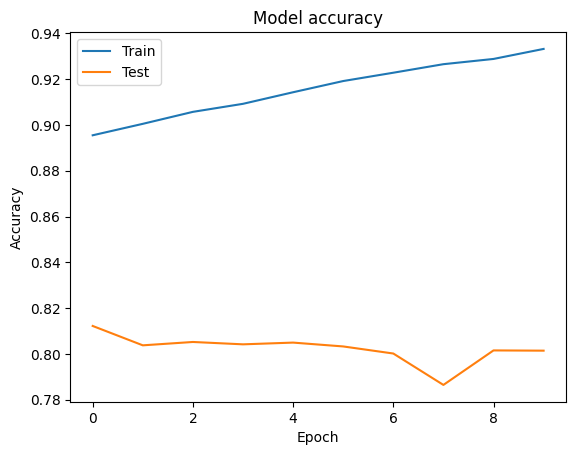

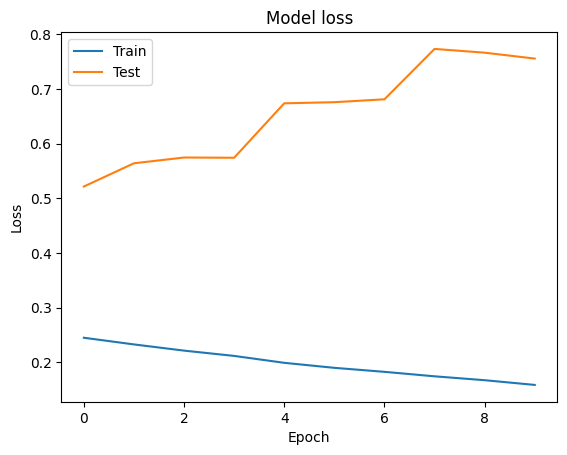

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(hisotry.history['accuracy'])
plt.plot(hisotry.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hisotry.history['loss'])
plt.plot(hisotry.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          4620600   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 384)               0

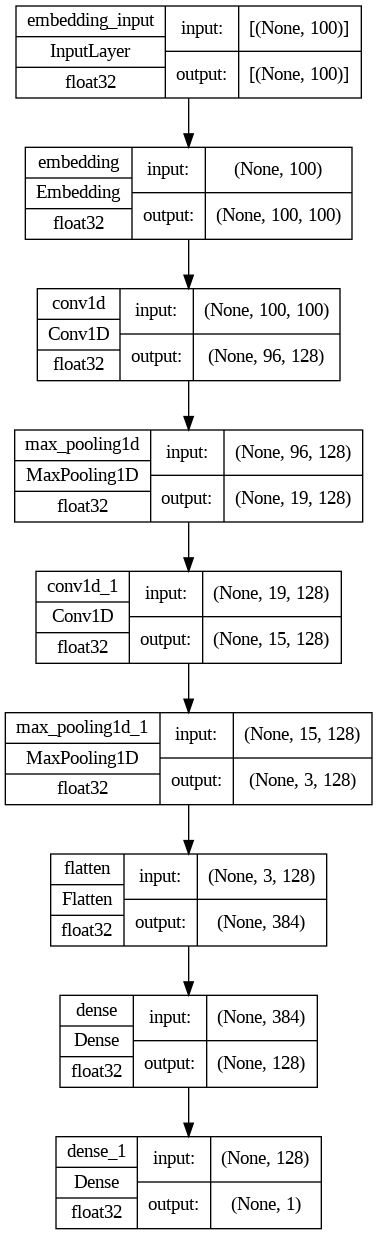

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_dtype=True,
                       show_layer_names=True, show_shapes=True,
                       to_file='model.png')

#Clustering

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk
import pandas as pd
import numpy as np


In [ ]:
df = pd.read_csv("df.csv")[["title"]].drop_duplicates()
df.head()

,title
0,banks will not donate money to boy scouts
1,walmarts image takes another beating walmarts ...
3,home depot severs paula deen ties
5,harnessing the power of stories that heal
8,taste kelloggs bet on racial healing


In [ ]:
#Remove Stope words
word_file = 'stopwords.txt'

with open(word_file, 'r') as file:
    words = file.readlines()

# Create a dictionary
word_dict = {word.strip(): None for word in words}
df = df[~df['title'].str.split().apply(lambda x: any(item in word_dict for item in x))]
df["title"] = df['title'].str.replace('[^a-zA-Z]', ' ', regex=True)
df.head()

,title
3,home depot severs paula deen ties
33,families dominate michigans best nonpublic com...
38,oped gop finds obamacare basically conservative
56,kellogg community college picks next president
60,dollar general corporation reports fourth quar...


In [ ]:
from gensim.models import Word2Vec

sentences = []
for _,row in df.iterrows():
  sentences += [row["title"].split(" ")]

model = Word2Vec(sentences,
                 window=5,     # Context window size
                 min_count=3,  # Ignore words with frequency lower than this
                 sg=1,         # Use CBOW algorithm
                 hs=0,         # Use negative sampling
                 negative=5    # Number of negative samples
                )

In [ ]:
X = model.wv.index_to_key
vectors = [model.wv[word] for word in X]

In [ ]:
vectors_array = np.array(vectors)
NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(vectors_array, assign_clusters=True)

##Graphing

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectors_array)

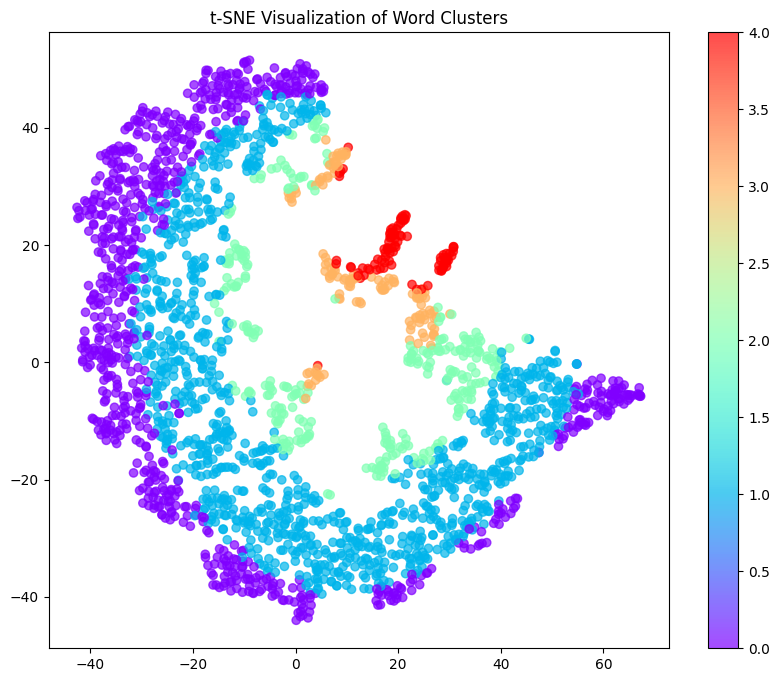

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=assigned_clusters, cmap='rainbow', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Visualization of Word Clusters')
plt.show()

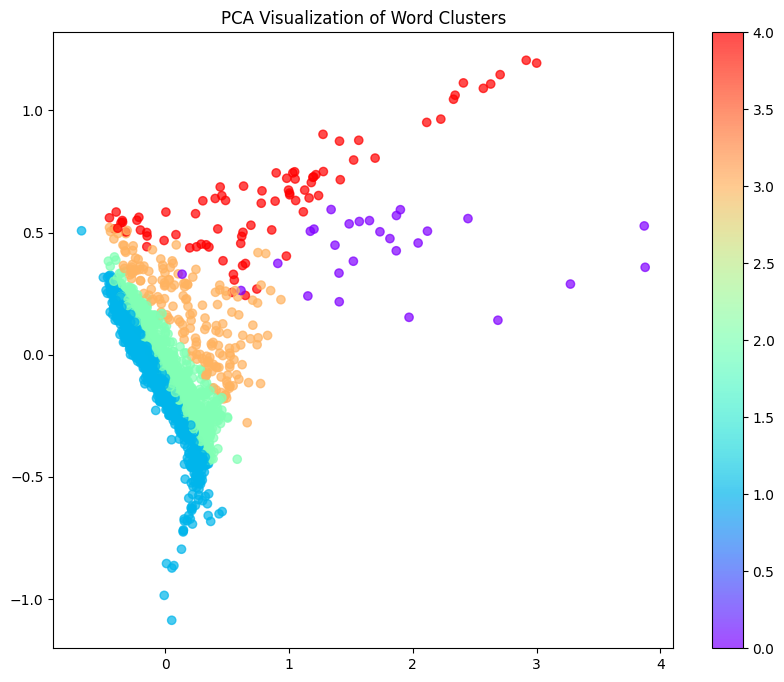

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(vectors_array)

plt.figure(figsize=(10, 8))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=assigned_clusters, cmap='rainbow', alpha=0.7)
plt.colorbar()
plt.title('PCA Visualization of Word Clusters')
plt.show()


In [ ]:
from wordcloud import WordCloud
from collections import Counter

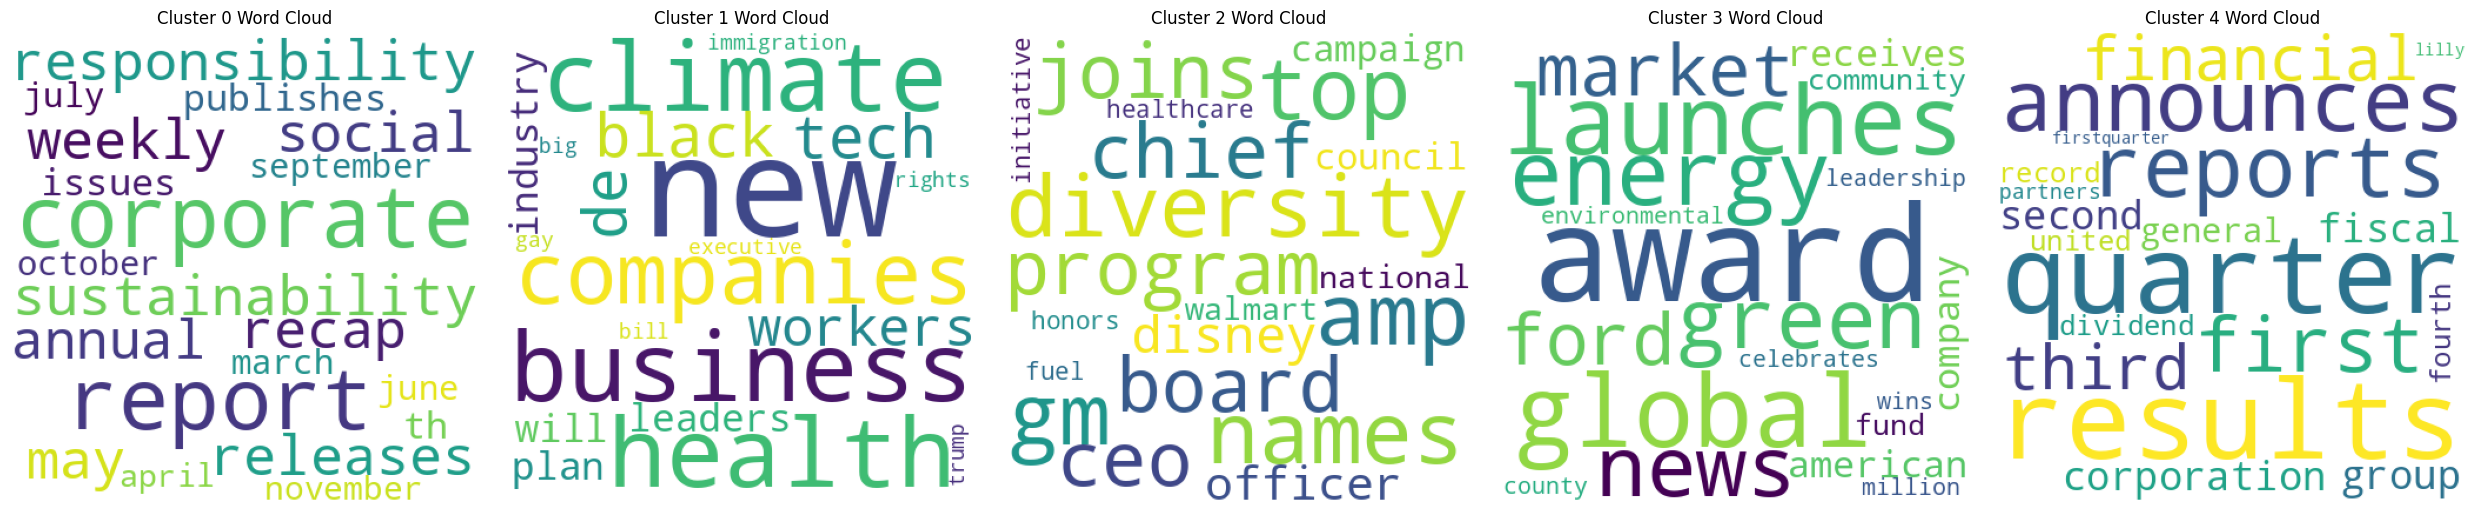

In [ ]:
def create_wordcloud(cluster_num, assigned_clusters, words, ax):
    cluster_words = [words[i] for i, cluster in enumerate(assigned_clusters) if cluster == cluster_num]
    word_freq = Counter(cluster_words)
    top_words = [word for word, freq in word_freq.most_common(20)]

    text = ' '.join(top_words)
    wordcloud = WordCloud(background_color='white', width=400, height=400).generate(text)

    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f'Cluster {cluster_num} Word Cloud')

unique_clusters = set(assigned_clusters)
num_clusters = len(unique_clusters)
num_cols = num_clusters

fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))
axes = axes.flatten()

for i, cluster_num in enumerate(unique_clusters):
    create_wordcloud(cluster_num, assigned_clusters, X, axes[i])

plt.tight_layout()
plt.show()


In [ ]:
model.wv.most_similar('netflix', topn=5)

[('jobs', 0.9977457523345947),
 ('policies', 0.9976384043693542),
 ('gop', 0.9975550174713135),
 ('talks', 0.9975020885467529),
 ('oppose', 0.9974939227104187)]

In [ ]:
word_categories = {
    'Climate': ['climate', 'sustainability', 'emissions', 'greenhouse', 'carbon', 'green', 'renewable'],
    'Racism': ['racism', 'black', 'discrimination', 'diversity', 'brutality', 'voter', 'healthcare', 'incarceration', 'criminal', 'racial'],
    "Women's Issues": ['feminism', 'abortion','women','gender','empowerment', 'wage', 'harassment', 'maternal', 'reproductive'],
    'LGBTQ issues': ['lgbtq','gay','trans', 'marriage', 'pride', 'inclusive'],
    'Immigration': ['immigration', 'refugees', 'daca', 'dreamers', 'border', 'visa', 'asylum', 'undocumented', 'deportation']
}

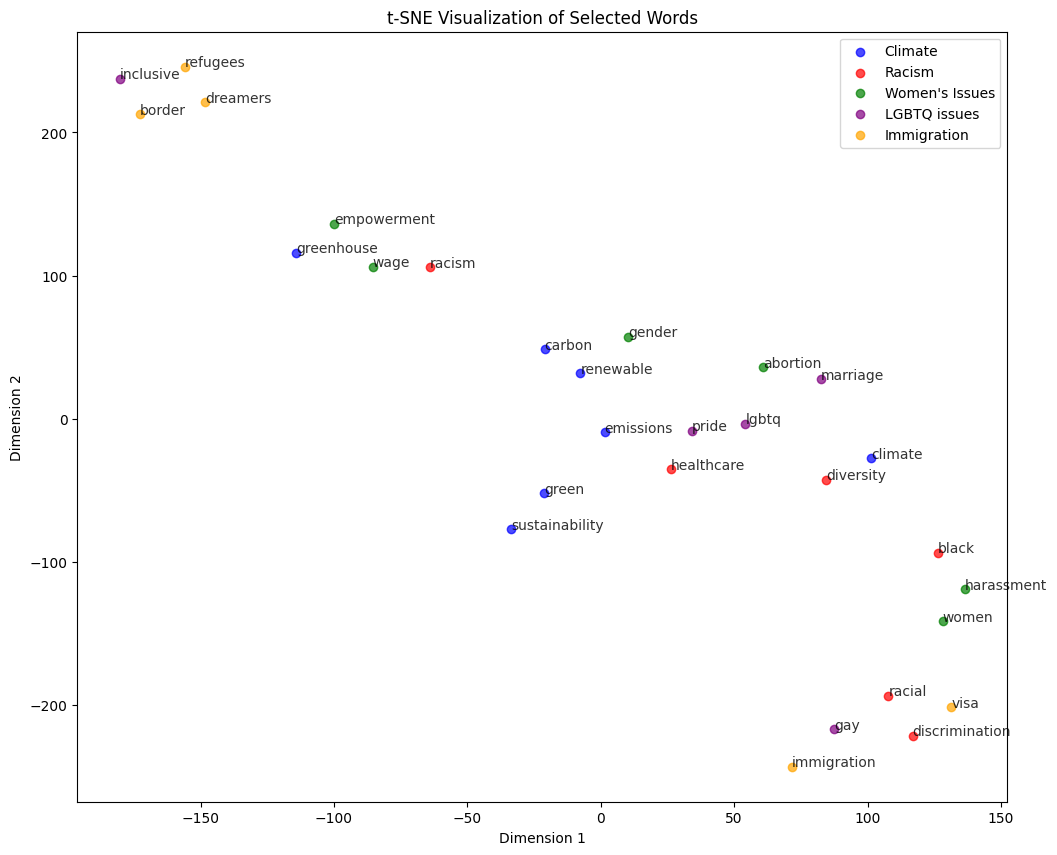

In [ ]:
combined_vectors = []
combined_words = []
word_colors = []

for category, words in word_categories.items():
    vectors = [(word, model.wv[word]) for word in words if word in model.wv.key_to_index]
    filtered_words, vectors = zip(*vectors)
    combined_vectors.extend(vectors)
    combined_words.extend(filtered_words)
    word_colors.extend([category]*len(filtered_words))

combined_vectors = np.array(combined_vectors)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_results = tsne.fit_transform(combined_vectors)

category_colors = {
    'Climate': 'blue',
    'Racism': 'red',
    "Women's Issues": 'green',
    'LGBTQ issues': 'purple',
    'Immigration': 'orange'
}

plt.figure(figsize=(12, 10))

for category, color in category_colors.items():
    indices = [i for i, word_color in enumerate(word_colors) if word_color == category]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=color, label=category, alpha=0.7)

for i, word in enumerate(combined_words):
    plt.annotate(word, (tsne_results[i, 0], tsne_results[i, 1]), alpha=0.8)

plt.title('t-SNE Visualization of Selected Words')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()
